<a href="https://colab.research.google.com/github/manideep03/Weed-Detection/blob/main/weed_detection_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Weed Detection

In [ ]:
# I used Kaggle API for downloading dataset 
## instaling kaggle api
!pip install kaggle

In [ ]:
# uploading API from local PC
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Some changes and permission in cloud
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
# Downloading Dataset
!kaggle datasets download -d gavinarmstrong/open-sprayer-images

 99% 558M/564M [00:07<00:00, 61.9MB/s]
100% 564M/564M [00:07<00:00, 79.0MB/s]


In [ ]:
# Unziping dataset
!unzip /content/open-sprayer-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: docknet/Docknet/train/notdocks/13091_8799_21970.jpg  
  inflating: docknet/Docknet/train/notdocks/13095_28002_28773.jpg  
  inflating: docknet/Docknet/train/notdocks/13099_10930_20055.jpg  
  inflating: docknet/Docknet/train/notdocks/130_6660_15715.jpg  
  inflating: docknet/Docknet/train/notdocks/13107_9640_15979.jpg  
  inflating: docknet/Docknet/train/notdocks/13111_27770_7433.jpg  
  inflating: docknet/Docknet/train/notdocks/13116_4044_19348.jpg  
  inflating: docknet/Docknet/train/notdocks/13125_3351_32242.jpg  
  inflating: docknet/Docknet/train/notdocks/13146_24152_28271.jpg  
  inflating: docknet/Docknet/train/notdocks/13147_13672_1915.jpg  
  inflating: docknet/Docknet/train/notdocks/13150_23474_13725.jpg  
  inflating: docknet/Docknet/train/notdocks/13178_21825_4683.jpg  
  inflating: docknet/Docknet/train/notdocks/13181_11205_1151.jpg  
  inflating: docknet/Docknet/train/notdocks/13181_16612_9464.jpg  
  inflati

In [ ]:
# Deleting unwanted data
!rm -rf "/content/docknet"
!rm -rf "/content/open-sprayer-images.zip"

#### Exploring Dataset

In [ ]:
import os
print("Folders in dataset :",os.listdir('/content/Docknet'))

Folders in dataset : ['valid', 'train']


In [ ]:
print("Folders in traning set :",os.listdir('/content/Docknet/train'))
print("Folders in validation set :",os.listdir('/content/Docknet/valid'))

Folders in traning set : ['docks', 'notdocks']
Folders in validation set : ['docks', 'notdocks']


In [ ]:
print("Total images in 'train/docks' folder :",len(os.listdir('/content/Docknet/train/docks')))
print("Total images in 'train/notdocks' folder :",len(os.listdir('/content/Docknet/train/notdocks')))
print("Total images in 'valid/docks' folder :",len(os.listdir('/content/Docknet/valid/docks')))
print("Total images in 'valid/notdocks' folder :",len(os.listdir('/content/Docknet/valid/notdocks')))

Total images in 'train/docks' folder : 1176
Total images in 'train/notdocks' folder : 4851
Total images in 'valid/docks' folder : 130
Total images in 'valid/notdocks' folder : 540


## 1 . Pre - Processing

In [ ]:
# requried libraries
## for image processing
import cv2
## for operating dataset
import os
## for visualizing graphs and images 
import matplotlib.pyplot as plt
## #visualizing for loops 
from tqdm import tqdm
import glob
## to display images only in colab
from google.colab.patches import cv_imshow
## for working with cnn's
import keras
## normalization function 
from tensorflow.keras.applications.inception_v3 import preprocess_input
## data agumentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# defining image size
img_size = 250 
# pre-processing function 
def preprocess(filename):
  ## reading images
  img = cv2.imread(filename)
  ## converting bgr to rgb color space
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ## center crop
  cropped_img = img[int((img.shape[0] - min(img.shape[0], img.shape[1]))/2): int((img.shape[0] + min(img.shape[0], img.shape[1]))/2), int((img.shape[1] - min(img.shape[0], img.shape[1]))/2): int((img.shape[1] + min(img.shape[0], img.shape[1]))/2), :]
  ## image resizing 
  img_ = cv2.resize(cropped_img, (img_size,img_size))
  ## converting pixel values to floats 
  img_normal = img_.astype("float32")
  ## applying normalization method
  img_final = preprocess_input(img_normal)
  ## returning image 
  return img_final

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pre-processed image
(250, 250, 3)


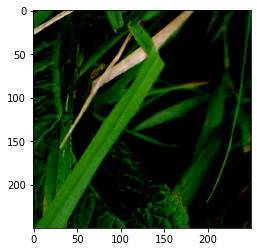

In [ ]:
## example of pre processed image
test_preimg = preprocess('/content/Docknet/train/docks/10021_11374_8504.jpg')
print("pre-processed image")
print(test_preimg.shape)
plt.imshow(test_preimg)

## Data Agumentation
- Sorting imbalance of dataset

In [ ]:
#train dataset path
train_path = '/content/Docknet/train/docks'
#getting all images paths
files = [f for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))]
#array to store all images after pre-processing
images = []
#array to store all labels
labels = []
#iterating to all files and storing into arrays
for f in tqdm(files):
  img = preprocess(os.path.join(train_path,f))
  images.append(img)
  labels.append(0)

100%|██████████| 1176/1176 [00:02<00:00, 500.04it/s]


In [ ]:
print("Total images in train set :",len(images))
print("Total labels in train set :",len(labels))

Total images in train set : 1176
Total labels in train set : 1176


In [ ]:
#folder for saving the augmented images
os.mkdir('/content/Docknet/train/aug_images')

In [ ]:
#data-agumentation 
import numpy as np

datagen = ImageDataGenerator(
    ## rescaling pixel values between [0,1]
    rescale = 1./255,
    ## moving image
    shear_range = 0.2,
    ## zooming into image
    zoom_range = 0.2,
    ## fliping image
    horizontal_flip=True)
i = 0
## saving agumented images to aug_images folder
for i in tqdm(range(5000)):
  id_ = np.random.randint(len(images))
  for batch in datagen.flow(np.expand_dims(images[id_], axis = 0), save_to_dir = '/content/Docknet/train/aug_images/', save_prefix = 'aug', save_format = 'jpeg'):
    break

100%|██████████| 5000/5000 [01:12<00:00, 68.74it/s]


In [ ]:
#checking total images in augmented folder
len(os.listdir('/content/Docknet/train/aug_images')) 

3939

- Data agumentation is completed now data is balenced. Moving forward to loading data

In [ ]:
#prepapre dataset for traning 

# part 1 : Loading all images in augumented folder 
path = '/content/Docknet/train/aug_images'    #path for folder
files = [i for i in os.listdir(path) if os.path.isfile(os.path.join(path,i))]     #getting all filenames in folder 
for f in files:
  image = preprocess(os.path.join(path,f))    #applying preprocessing function
  images.append(image)    #storing preprocessed image
  labels.append(0)        #storing corressponding label 

# part 2 : Loading all images in notdocks folder 
path = '/content/Docknet/train/notdocks'
files = [i for i in os.listdir(path) if os.path.isfile(os.path.join(path,i))]
for f in files:
  image = preprocess(os.path.join(path,f))
  images.append(image)
  labels.append(1)

# testing data loading 

test_images = []
test_labels = []

# part 1 : Loading all images in docks folder 

path = '/content/Docknet/valid/docks'
files = [i for i in os.listdir(path) if os.path.isfile(os.path.join(path,i))]
for f in files:
  image = preprocess(os.path.join(path,f))
  test_images.append(image)
  test_labels.append(0)
# part 1 : Loading all images in notdocks folder 
path = '/content/Docknet/valid/notdocks'
files = [i for i in os.listdir(path) if os.path.isfile(os.path.join(path,i))]
for f in files:
  image = preprocess(os.path.join(path,f))
  test_images.append(image)
  test_labels.append(1)

In [ ]:
# Shuffling traning data

from random import shuffle
#array to save shuffled images
train_images = []
#array to save shuffled labels
train_labels = []
index_shu = np.arange(len(images))
shuffle(index_shu)
for i in index_shu:
  train_images.append(images[i])
  train_labels.append(labels[i])
# printing all shapes to cross check
print(np.array(train_images).shape)
print(np.array(train_labels).shape)
print(np.array(test_images).shape)
print(np.array(test_labels).shape)

(9966, 250, 250, 3)
(9966,)
(670, 250, 250, 3)
(670,)


## 2 . Classification 

In [ ]:
#defining model
def model():
  #downloading InceptionV3 model weights 
  model = keras.applications.InceptionV3(include_top=False, input_shape=(250,250,3), weights='imagenet')
  #adding global avg pooling layer to model
  avg_layer = keras.layers.GlobalAveragePooling2D()(model.output)
  #adding a dense layer
  output_layer = keras.layers.Dense(2, activation='softmax')(avg_layer)
  #combining model
  final = keras.engine.training.Model(model.inputs, output_layer)
  return final

In [ ]:
#Getting model
model = model()

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
#Summary of model 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 124, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 124, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
#For fine tunning of model activating all layers except last 50 layers

for layer in model.layers:
  layer.trainable = True

for layer in model.layers[:-50]:
  layer.trainable = False

In [ ]:
# Compiling model with binary crossentropy because of only two classes
model.compile(
    loss = 'binary_crossentropy',
    optimizer = keras.optimizers.Adamax(learning_rate=1e-2),
    metrics = ['accuracy']
)

In [ ]:
#traning data batch generator function

import keras
BS = 32  #defining batch size
def train_gen(images,labels):
  i=0
  while True:           #running infinite loop
    batch_imgs = np.array(images[i:i+BS])   #getting the batch size images from arrays
    if (batch_imgs.shape[0] == 0):
      break
    batch_targets = np.array(labels[i:i+BS])
    batch_labels = keras.utils.to_categorical(batch_targets, 2)  #converting labels to one-hot-encoding 
    i+=BS
    yield batch_imgs, batch_labels

In [ ]:
# traning model
history = model.fit_generator(
    train_gen(train_images, train_labels), 
    steps_per_epoch=len(train_images) // BS // 8,
    epochs= 8
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/8
38/38 [==============================] - 2s 65ms/step - loss: 0.2772 - accuracy: 0.8980
Epoch 2/8
38/38 [==============================] - 2s 65ms/step - loss: 0.1986 - accuracy: 0.9260
Epoch 3/8
38/38 [==============================] - 3s 66ms/step - loss: 0.1597 - accuracy: 0.9449
Epoch 4/8
38/38 [==============================] - 3s 66ms/step - loss: 0.1299 - accuracy: 0.9572
Epoch 5/8
38/38 [==============================] - 2s 65ms/step - loss: 0.1321 - accuracy: 0.9507
Epoch 6/8
38/38 [==============================] - 2s 65ms/step - loss: 0.1409 - accuracy: 0.9498
Epoch 7/8
38/38 [==============================] - 2s 65ms/step - loss: 0.1344 - accuracy: 0.9539
Epoch 8/8
38/38 [==============================] - 2s 65ms/step - loss: 0.1251 - accuracy: 0.9572


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


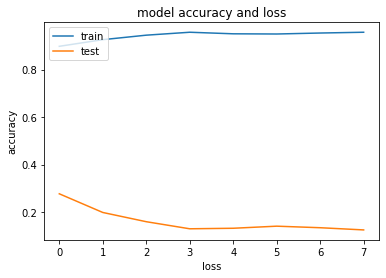

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy')
plt.xlabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Classification

#### CNN+Softmax 

In [ ]:
#Simple functions for displaying and showing predicted label

label = ['Docks','NotDocks']
def preprocess_out(filename):
  img = cv2.cvtColor(filename, cv2.COLOR_BGR2RGB)
  cropped_img = img[int((img.shape[0] - min(img.shape[0], img.shape[1]))/2): int((img.shape[0] + min(img.shape[0], img.shape[1]))/2), int((img.shape[1] - min(img.shape[0], img.shape[1]))/2): int((img.shape[1] + min(img.shape[0], img.shape[1]))/2), :]
  img_ = cv2.resize(cropped_img, (img_size,img_size))
  img_normal = img_.astype("float32")
  img_final = preprocess_input(img_normal)
  return img_final
def predict(img_path):
  img = cv2.imread(img_path)
  cv_imshow(img)
  imgTest = preprocess_out(img)
  imgtest = np.array(imgTest)
  imgtest = np.expand_dims(imgtest,axis=0)
  pred = model.predict(imgtest)
  val = np.argmax(pred)
  print(val)
  print('Predicted Label :', label[val])

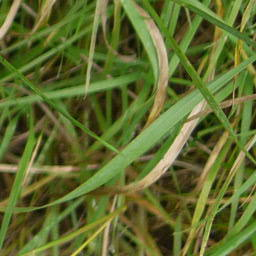

1
Predicted Label : NotDocks


In [ ]:
#testing on a image from testing folder
predict('/content/Docknet/valid/notdocks/1101_18561_27166.jpg')

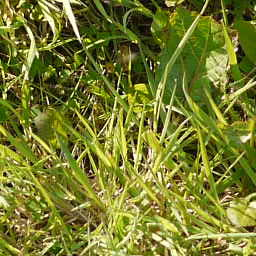

0
Predicted Label : Docks


In [ ]:
predict('/content/Docknet/valid/docks/851_15478_26020.jpg')

In [ ]:
# CNN
train_predictions = []
print("loading traning images !!!")
for i,file in enumerate(train_images):
    file = np.reshape(file, [1, file.shape[0], file.shape[1], file.shape[2]])
    prediction = model.predict(file)
    prediction = np.argmax(prediction)
    train_predictions.append(prediction)
    
test_predictions = []
print("loading testing images !!!")
for i,file in enumerate(test_images):
    file = np.reshape(file, [1, file.shape[0], file.shape[1], file.shape[2]])
    prediction = model.predict(file)
    prediction = np.argmax(prediction)
    test_predictions.append(prediction)


loading traning images !!!
loading testing images !!!


In [ ]:
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(np.array(train_predictions), 
                                     np.array(train_labels))
test_acc = accuracy_score(np.array(test_predictions), 
                                     np.array(test_labels))

print('Train Accuray:' + str(train_acc))
print('Validation Accuray:' + str(test_acc))

Train Accuray:0.9489263495886012
Validation Accuray:0.8940298507462686


#### CNN+SVM


In [ ]:
from sklearn.svm import SVC
from keras.models import Model
svm = SVC(kernel='rbf', probability=True)
model_feat = Model(inputs=model.input,outputs=model.get_layer('global_average_pooling2d').output)

In [ ]:
## extracting features from model
feature_matrix = []
for item in tqdm(train_images):
    item = np.reshape(item, [1, item.shape[0], item.shape[1], item.shape[2]])
    feat_train = model_feat.predict(item)
    feature_matrix.append(feat_train)
np.array(feature_matrix)

s = len(feature_matrix)
import pandas as pd
feature_matrix = np.reshape(np.array(feature_matrix), (s, 2048))
pd.DataFrame(np.array(feature_matrix)).to_csv("features.csv")

100%|██████████| 9966/9966 [07:13<00:00, 22.98it/s]


In [ ]:
# Load generated feature matrix
import pandas as pd
test_fm = pd.read_csv('features.csv', index_col = 0).values

In [ ]:
# Train and Save SVM Model
import pickle
from sklearn import model_selection
svm.fit(test_fm,np.array(train_labels))
print('fitting done !!!')
filename = 'finalized_svm_model.sav'
pickle.dump(svm, open(filename, 'wb'))

fitting done !!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


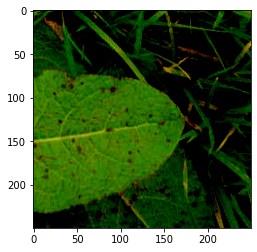

0


In [ ]:
# Prediction with CNN + Softmax
img = preprocess("/content/Docknet/train/docks/3112_14280_24573.jpg")
plt.imshow(img)
plt.show()
img = np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]])
prediction = model.predict(img)
print(np.argmax(prediction))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


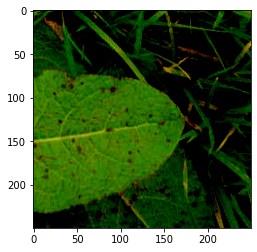

array([0])

In [ ]:
# Prediction with CNN + SVM
img = preprocess("/content/Docknet/train/docks/3112_14280_24573.jpg")
plt.imshow(img)
plt.show()
img = np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]])
prediction = model_feat.predict(img)
prediction = svm.predict(prediction)
prediction

In [ ]:
# CNN + SVM
import sklearn

val_feature_matrix = []
for item in test_images:
    item = np.reshape(item, [1, item.shape[0], item.shape[1], item.shape[2]])
    feat_train = model_feat.predict(item)
    val_feature_matrix.append(feat_train)
val_feature_matrix = np.array(val_feature_matrix)[:,0,:]

print('Train Accuracy: ' + str(svm.score(test_fm,train_labels)))
print('Validation Accuracy: ' + str(svm.score(val_feature_matrix,test_labels)))

Train Accuracy: 0.976319486253261
Validation Accuracy: 0.9283582089552239


#### CNN+Random forest

In [ ]:
#CNN + Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Model
import pandas as pd

rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)

rf.fit(test_fm,np.array(train_labels))
print('fitting done !!!')

# Save RF Model
import pickle
from sklearn import model_selection
filename = 'finalized_rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

fitting done !!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


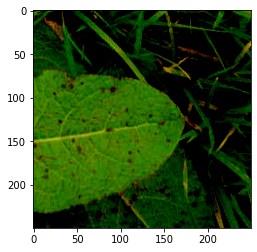

array([0])

In [ ]:
# Prediction with CNN + Random Forests Classifier
img = preprocess("/content/Docknet/train/docks/3112_14280_24573.jpg")
plt.imshow(img)
plt.show()
img = np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]])
prediction = model_feat.predict(img)
prediction = rf.predict(prediction)
prediction

In [ ]:
import sklearn

val_feature_matrix = []
for item in tqdm(test_images):
    item = np.reshape(item, [1, item.shape[0], item.shape[1], item.shape[2]])
    feat_train = model_feat.predict(item)
    val_feature_matrix.append(feat_train)
val_feature_matrix = np.array(val_feature_matrix)[:,0,:]

print('Train Accuracy: ' + str(rf.score(test_fm,np.array(train_labels))))
print('Validation Accuracy: ' + str(rf.score(val_feature_matrix,np.array(test_labels))))

100%|██████████| 670/670 [00:28<00:00, 23.43it/s]


Train Accuracy: 0.9762191450933173
Validation Accuracy: 0.9343283582089552


#### CNN + Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

dt = DecisionTreeClassifier(random_state=0)
dt.fit(test_fm,np.array(train_labels))
print('fitting done !!!')

import pickle
filename = 'finalized_dt_model.sav'
pickle.dump(dt, open(filename, 'wb'))

fitting done !!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


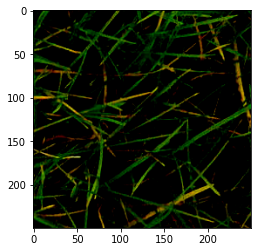

array([1])

In [ ]:
img = preprocess("/content/Docknet/valid/notdocks/347_22859_1880.jpg")
plt.imshow(img)
plt.show()
img = np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]])
prediction = model_feat.predict(img)
prediction = dt.predict(prediction)
prediction

In [ ]:
import sklearn

val_feature_matrix = []
for item in test_images:
    item = np.reshape(item, [1, item.shape[0], item.shape[1], item.shape[2]])
    feat_train = model_feat.predict(item)
    val_feature_matrix.append(feat_train)
val_feature_matrix = np.array(val_feature_matrix)[:,0,:]

print('Train Accuracy: ' + str(dt.score(test_fm,np.array(train_labels))) + '\n')
print('Validation Accuracy: ' + str(dt.score(val_feature_matrix,np.array(test_labels))))

Train Accuracy: 1.0

Validation Accuracy: 0.9164179104477612


AUC(SVM): 0.946
AUC(RF): 0.938
AUC(DT): 0.866
AUC(Softmax): 0.929


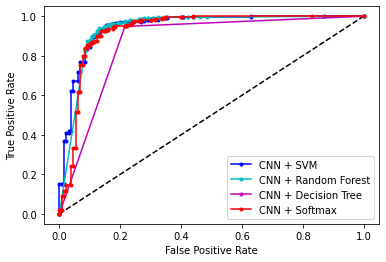

In [ ]:
# roc curve and auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# CNN + SVM
probs = svm.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(np.array(test_labels), probs)
print('AUC(SVM): %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(np.array(test_labels), probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--', color = 'k')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='CNN + SVM', color = 'b')

# CNN + RF
probs = rf.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(np.array(test_labels), probs)
print('AUC(RF): %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(np.array(test_labels), probs)
# plot no skill
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='CNN + Random Forest', color = 'c')

# CNN + DT
probs = dt.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(np.array(test_labels), probs)
print('AUC(DT): %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(np.array(test_labels), probs)
# plot no skill
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='CNN + Decision Tree', color = 'm')


# CNN + Softmax
probs = []
for i,file in enumerate(test_images):
    file = np.reshape(file, [1, file.shape[0], file.shape[1], file.shape[2]])
    prediction = model.predict(file)
    probs.append(prediction)
probs = np.array(probs)
probs = np.reshape(probs, (probs.shape[0],2))
probs = probs[:,1]
auc = roc_auc_score(np.array(test_labels), probs)
print('AUC(Softmax): %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(np.array(test_labels), probs)
# plot no skill
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='CNN + Softmax', color = 'r')


# show the plot
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
pyplot.show()

## precision-recall curve

CNN + SVM: f1=0.956 ap=0.981
CNN + RF: f1=0.960 ap=0.973
CNN + DT: f1=0.948 ap=0.941
CNN + Softmax: f1=0.932 ap=0.967


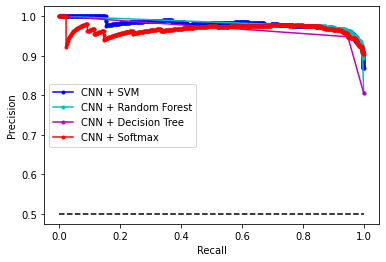

In [ ]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

# CNN + SVM
probs = svm.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = svm.predict(val_feature_matrix)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(np.array(test_labels), probs)
# calculate F1 score
f1 = f1_score(np.array(test_labels), yhat)
# calculate average precision score
ap = average_precision_score(np.array(test_labels), probs)
print('CNN + SVM: f1=%.3f ap=%.3f' % (f1, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--', color='k')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.', label='CNN + SVM', color='b')

# CNN + RF
probs = rf.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = rf.predict(val_feature_matrix)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(np.array(test_labels), probs)
# calculate F1 score
f1 = f1_score(np.array(test_labels), yhat)
# calculate average precision score
ap = average_precision_score(np.array(test_labels), probs)
print('CNN + RF: f1=%.3f ap=%.3f' % (f1, ap))
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.', label='CNN + Random Forest', color='c')

# CNN + DT
probs = dt.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = dt.predict(val_feature_matrix)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(np.array(test_labels), probs)
# calculate F1 score
f1 = f1_score(np.array(test_labels), yhat)
# calculate average precision score
ap = average_precision_score(np.array(test_labels), probs)
print('CNN + DT: f1=%.3f ap=%.3f' % (f1, ap))
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.', label='CNN + Decision Tree', color='m')

# CNN + Softmax
probs = []
for i,file in enumerate(test_images):
    file = np.reshape(file, [1, file.shape[0], file.shape[1], file.shape[2]])
    prediction = model.predict(file)
    probs.append(prediction)
probs = np.array(probs)
probs = np.reshape(probs, (probs.shape[0],2))
probs = probs[:,1]

yhat = []
for i,file in enumerate(test_images):
    file = np.reshape(file, [1, file.shape[0], file.shape[1], file.shape[2]])
    prediction = model.predict(file)
    prediction = np.argmax(prediction)
    yhat.append(prediction)
probs = np.array(probs)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(np.array(test_labels), probs)
# calculate F1 score
f1 = f1_score(np.array(test_labels), yhat)
# calculate average precision score
ap = average_precision_score(np.array(test_labels), probs)
print('CNN + Softmax: f1=%.3f ap=%.3f' % (f1, ap))
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.', label='CNN + Softmax', color='r')

# show the plot
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
pyplot.show()